In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import vice.benchmark

In [5]:
def run_transit(nevals, tols, N=1000, K=50, J=1):
    data = []
    
    adapt_names = ["trapezoid_adapt", "simpson_adapt"]
    fixed_names = ["trapezoid_fixed", "simpson_fixed", "riemann"]
    
    for k in range(K):
        texp = np.exp(np.random.uniform(np.log(0.01), np.log(0.1)))
        q1, q2 = np.random.rand(2)
        u = np.array([2.0 * np.sqrt(q1) * q2, np.sqrt(q1) * (1.0 - 2.0 * q2)])
        r = np.exp(np.random.uniform(np.log(0.01), np.log(0.1)))
        b = np.random.uniform(0, 1 + r)
        tau = 1.0
        x = np.linspace(-0.5*(tau+texp), 0.5*(1+texp), N)

        fl_exact = vice.benchmark.transit_exact(u, r, b, tau, x, texp)
        
        for i, name in enumerate(adapt_names + fixed_names):
            params = tols if name in adapt_names else nevals
            for j, param in enumerate(params):
                f = getattr(vice.benchmark, "transit_" + name)
                times = []
                for _ in range(J):
                    fl, num, time = f(u, r, b, tau, x, texp, param)
                    times.append(time)
                time = np.mean(times)
                resid = np.abs(fl - fl_exact)
                data.append((k, name, i, param, j, texp,
                             np.log10(np.sum(num)),
                             np.log10(time),
                             np.log10(np.sum(resid**2)),
                             np.log10(np.mean(resid)),
                             np.log10(np.max(resid)),
                             q1, q2, r, b))
    
    names = ["version", "method", "method_id", "param", "param_id", "texp",
             "log10_num", "log10_time", "log10_l2", "log10_mean_err", "log10_max_err",
             "q1", "q2", "r", "b"]
    return pd.DataFrame(dict(zip(names, zip(*data))))

In [6]:
nevals = 3 * 2 ** np.arange(7)
tols = 10**np.arange(-13., -1., 1)

In [7]:
df = run_transit(nevals, tols)

In [8]:
mean_grp = df.groupby(("method", "param_id")).median()
std_grp = df.groupby(("method", "param_id")).std()

[Text(0,0,'ppb'), Text(0,0,'ppm')]

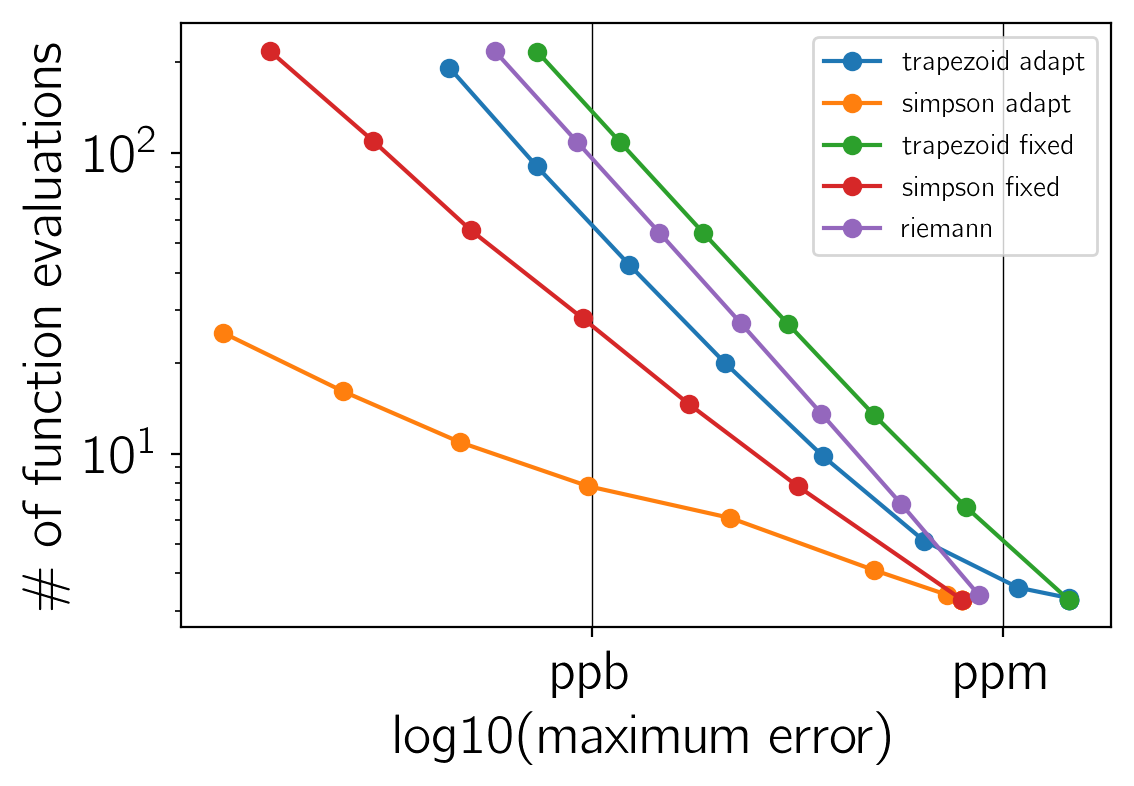

In [9]:
for method in df.method.unique():
    x = np.array(mean_grp.loc[method].log10_max_err)
    y = 10**(np.array(mean_grp.loc[method].log10_num) - np.log10(1000))
    
    inds = np.argsort(x)
    plt.errorbar(x[inds], y[inds],
                 fmt="o-", label=method.replace("_", " "))

plt.axvline(-6, color="k", linewidth=0.5)
plt.axvline(-9, color="k", linewidth=0.5)
# plt.axhline(10, color="k", linewidth=0.5)
# plt.axhline(100, color="k", linewidth=0.5)

plt.ylabel("\# of function evaluations")
plt.xlabel("log10(maximum error)")
plt.yscale("log")
plt.legend(fontsize=10)
ax = plt.gca()
ax.set_xticks([-9, -6])
ax.set_xticklabels(["ppb", "ppm"])

In [12]:
np.random.seed(42)
texp = 0.2
q1, q2 = np.random.rand(2)
u = np.array([2.0 * np.sqrt(q1) * q2, np.sqrt(q1) * (1.0 - 2.0 * q2)])
r = 0.05
b = 0.5
tau = 1.0

N = 1000
x = np.linspace(0, 0.5*tau + 0.5*texp + texp, N)
flux = vice.benchmark.transit_flux(u, r, b, tau, x)
fl_exact = vice.benchmark.transit_exact(u, r, b, tau, x, texp)
fl_riemann = vice.benchmark.transit_riemann(u, r, b, tau, x, texp, 3)
fl_simpson = vice.benchmark.transit_simpson_adapt(u, r, b, tau, x, texp, 1e-1)

print(np.sum(fl_riemann[1]), np.sum(fl_simpson[1]))

4500 4000


Text(0.5,0,'time since transit')

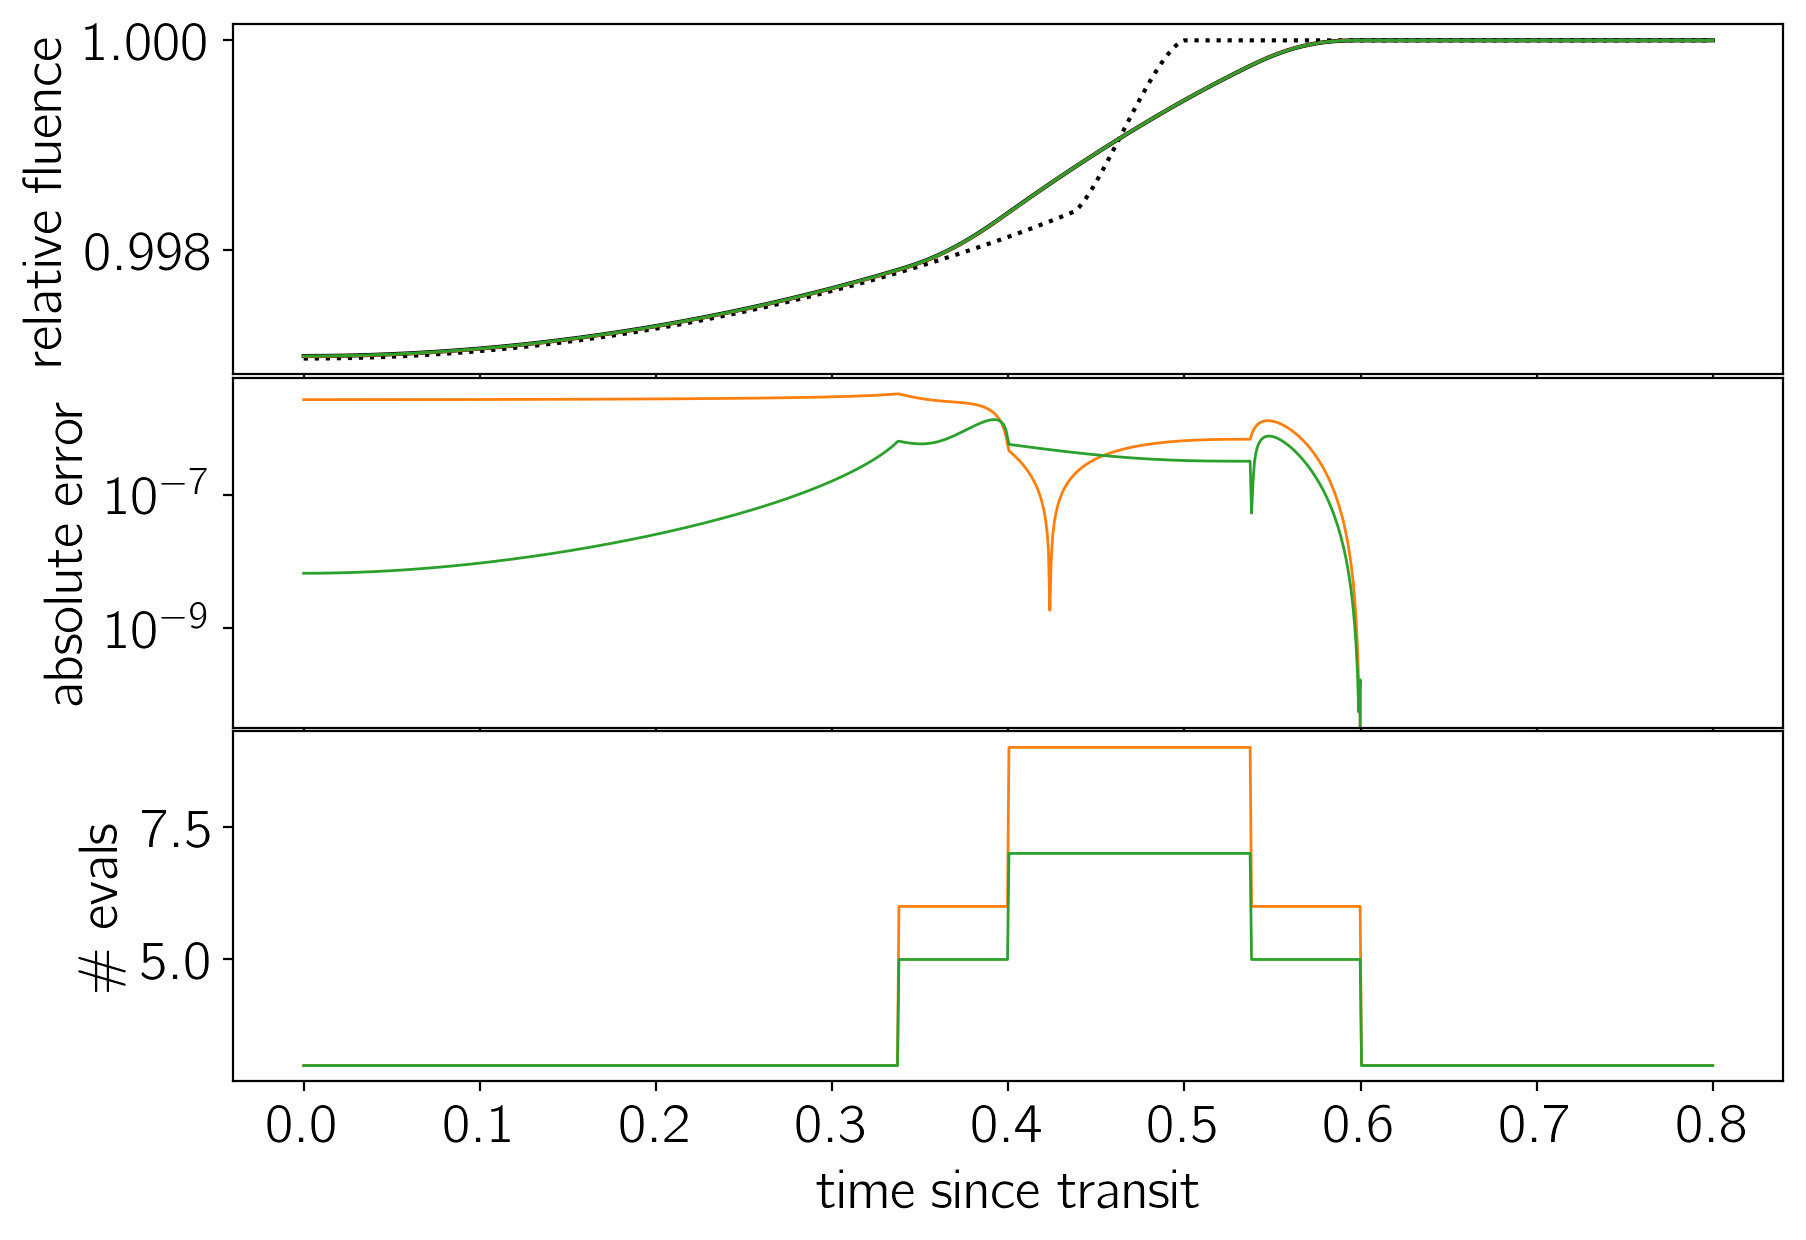

In [13]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 7))
fig.subplots_adjust(hspace=0.01)

ax = axes[0]
ax.plot(x, flux, ":k", lw=1.5)
ax.plot(x, fl_exact, "k", lw=1.5)
ax.plot(x, fl_riemann[0], color="C1", lw=1)
ax.plot(x, fl_simpson[0], color="C2", lw=1)
ax.set_ylabel("relative fluence")

ax = axes[1]
ax.plot(x, np.abs(fl_riemann[0]-fl_exact), color="C1", lw=1, label="Riemann")
ax.plot(x, np.abs(fl_simpson[0]-fl_exact), color="C2", lw=1, label="adaptive Simpson")
ax.set_yscale("log")
ax.set_ylabel("absolute error")

ax = axes[2]
ax.plot(x, fl_riemann[1], color="C1", lw=1)
ax.plot(x, fl_simpson[1], color="C2", lw=1)
ax.set_ylabel("\# evals")
ax.set_xlabel("time since transit")